/tmp/ipython-input-2237703322.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("turbo")


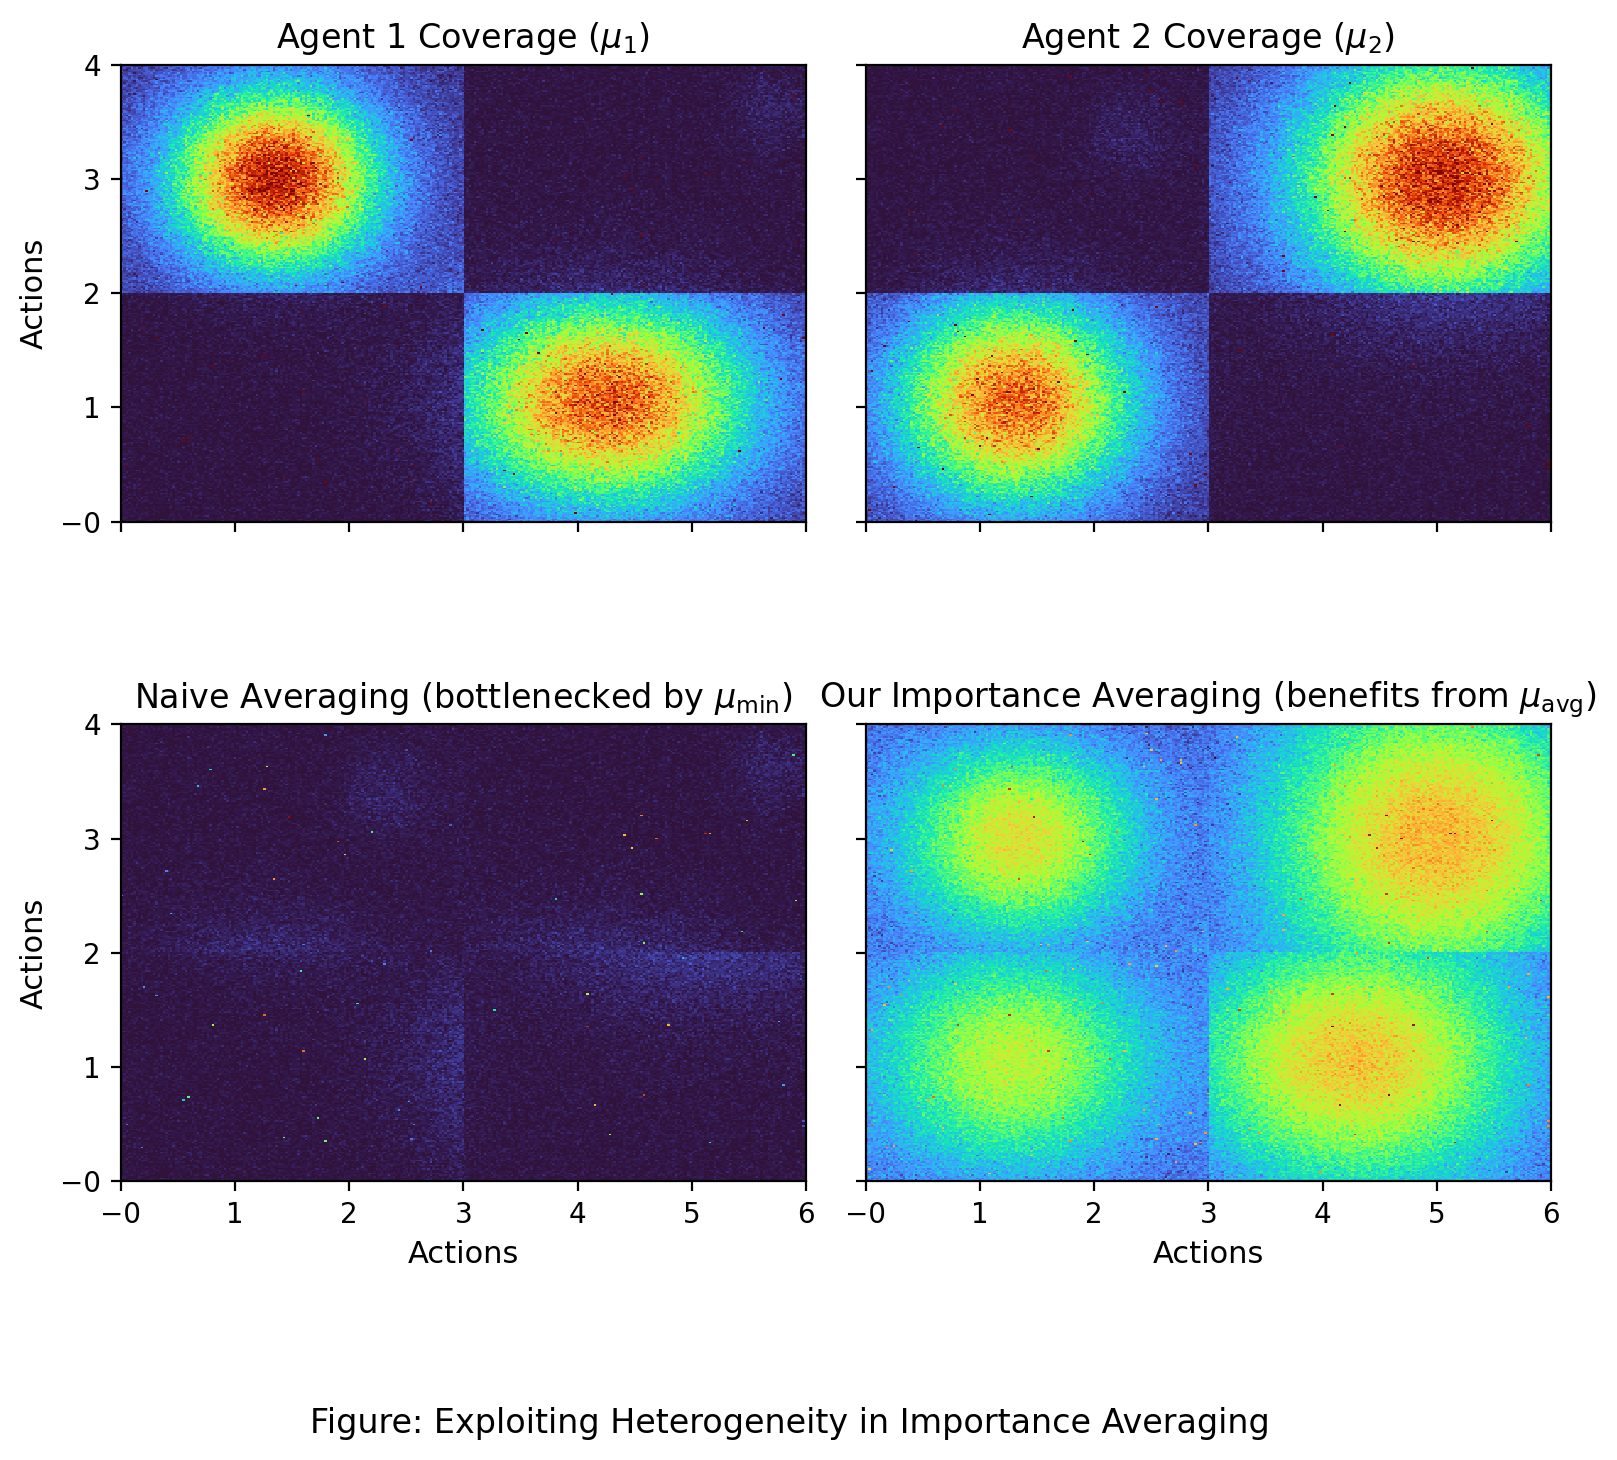

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams.update({
    "figure.dpi": 200,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "DejaVu Sans",
})


rng = np.random.default_rng(20250922)
W, H = 280, 280
x = np.linspace(0, 6, W)
y = np.linspace(0, 4, H)
X, Y = np.meshgrid(x, y)

def gaussian(cx, cy, sx, sy):
    return np.exp(-(((X - cx) / sx) ** 2 + ((Y - cy) / sy) ** 2) / 2)


q_UL = (X <= 3) & (Y >= 2)
q_UR = (X > 3)  & (Y >= 2)
q_LL = (X <= 3) & (Y <  2)
q_LR = (X > 3)  & (Y <  2)


w1 = 0.95*q_UL + 0.10*q_UR + 0.10*q_LL + 0.90*q_LR + 0.02
w2 = 0.10*q_UL + 0.92*q_UR + 0.92*q_LL + 0.12*q_LR + 0.02


mu1_field = (
    1.20*gaussian(1.35, 3.00, 0.60, 0.52) +
    1.10*gaussian(4.25, 1.05, 0.85, 0.60) +
    0.20*gaussian(5.70, 3.60, 0.24, 0.24) +
    0.07
)
mu2_field = (
    1.25*gaussian(5.05, 3.00, 0.85, 0.72) +
    1.10*gaussian(1.30, 1.05, 0.70, 0.60) +
    0.20*gaussian(2.30, 3.40, 0.25, 0.25) +
    0.07
)
mu1 = w1 * mu1_field
mu2 = w2 * mu2_field


def poisson_texture(field, base_scale=80, salt_n=70, salt_int_range=(260, 430)):
    counts = rng.poisson(base_scale * field)
    ys = rng.integers(0, counts.shape[0], salt_n)
    xs = rng.integers(0, counts.shape[1], salt_n)
    counts[ys, xs] += rng.integers(salt_int_range[0], salt_int_range[1], salt_n)
    return counts

mu1_counts = poisson_texture(mu1, base_scale=80, salt_n=60)
mu2_counts = poisson_texture(mu2, base_scale=80, salt_n=85)


def qnorm(a, ql=0.002, qh=0.998):
    lo, hi = np.quantile(a, ql), np.quantile(a, qh)
    b = (a - lo) / (hi - lo + 1e-12)
    return np.clip(b, 0, 1)

mu1n = qnorm(mu1_counts)
mu2n = qnorm(mu2_counts)


mu_min = np.minimum(mu1n, mu2n)
mu_avg = 0.5 * (mu1n + mu2n)


mu_avg_disp = np.clip(
    mu_avg**0.58 + 0.05*np.sin((X - 3)/3*np.pi) + 0.025*rng.normal(size=mu_avg.shape),
    0, 1
)


cmap = mpl.cm.get_cmap("turbo")
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=200, sharex=True, sharey=True)

def draw(ax, Z, title):
    ax.imshow(Z, origin="lower", extent=[0, 6, 0, 4], interpolation="nearest",
              cmap=cmap, vmin=0, vmax=1)
    ax.set_xlim(0, 6); ax.set_ylim(0, 4)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title, fontsize=12)

    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_xticklabels([("−0" if t == 0 else str(t)) for t in [0,1,2,3,4,5,6]])
    ax.set_yticklabels([("−0" if t == 0 else str(t)) for t in [0,1,2,3,4]])


for ax in axes[0]:
    ax.set_xticklabels([])

draw(axes[0, 0], mu1n, r"Agent 1 Coverage ($\mu_1$)")
draw(axes[0, 1], mu2n, r"Agent 2 Coverage ($\mu_2$)")
draw(axes[1, 0], mu_min, r"Naive Averaging (bottlenecked by $\mu_{\min}$)")
draw(axes[1, 1], mu_avg_disp, r"Our Importance Averaging (benefits from $\mu_{\mathrm{avg}}$)")

for ax in axes[:, 0]:
    ax.set_ylabel("Actions")
for ax in axes[1, :]:
    ax.set_xlabel("Actions")

fig.tight_layout(rect=[0, 0.04, 1, 0.96])

fig.suptitle("Figure: Exploiting Heterogeneity in Importance Averaging", y=0.01, fontsize=12)
plt.show()

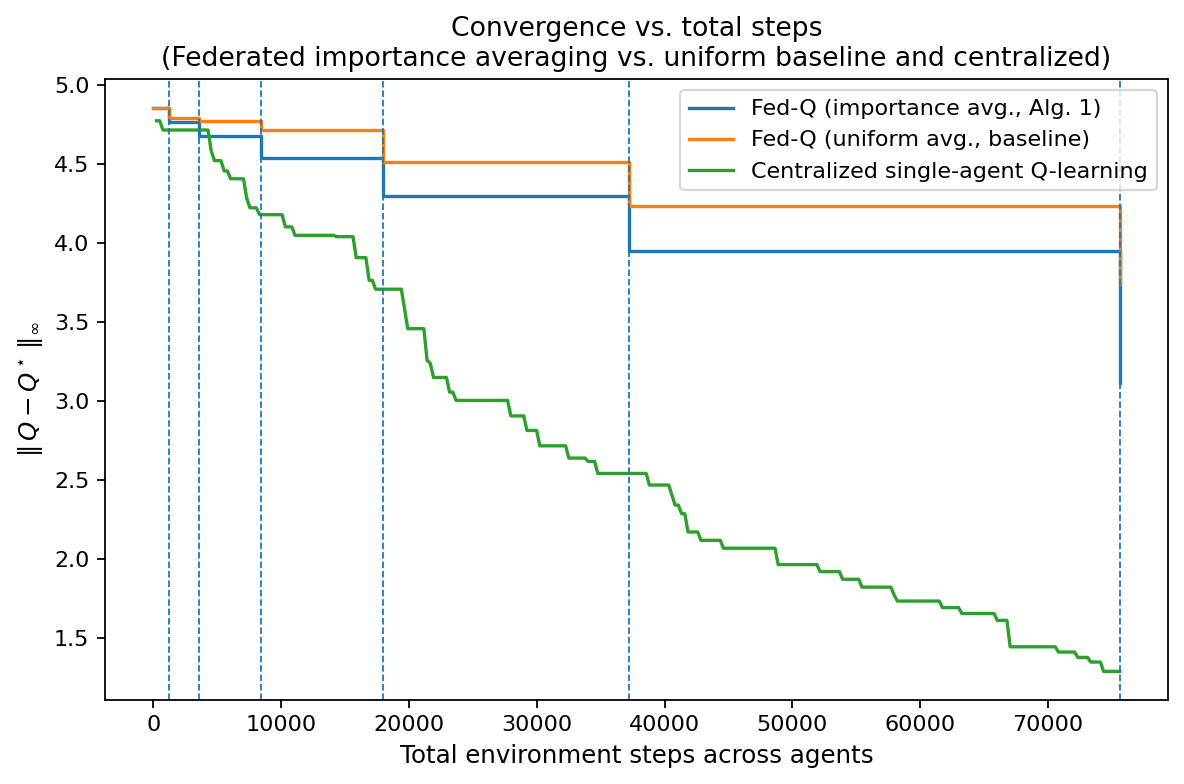

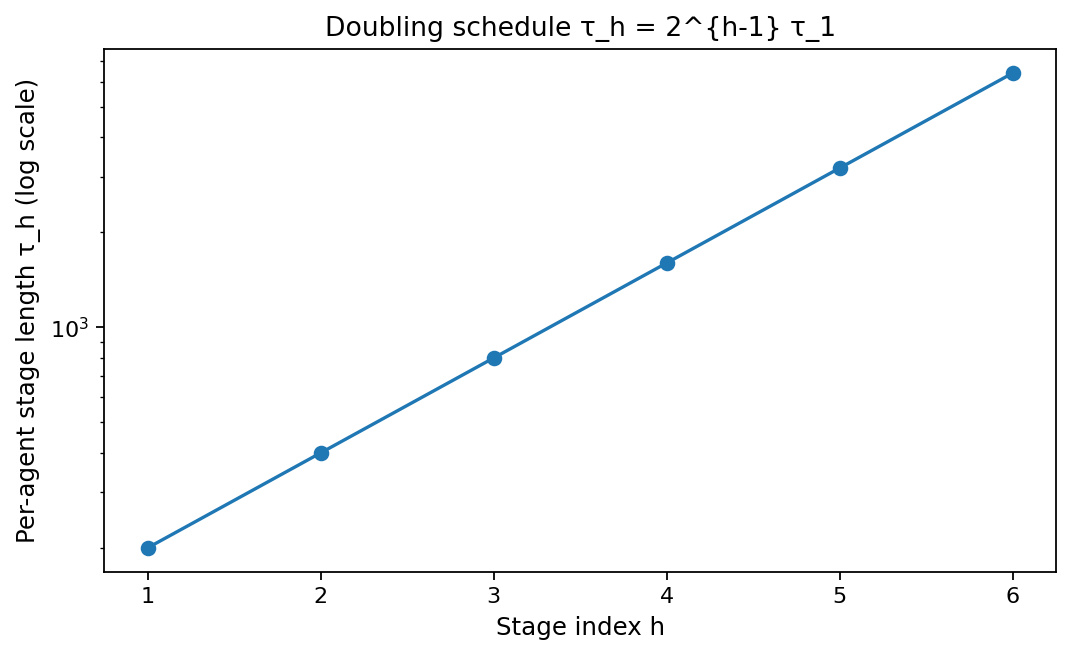

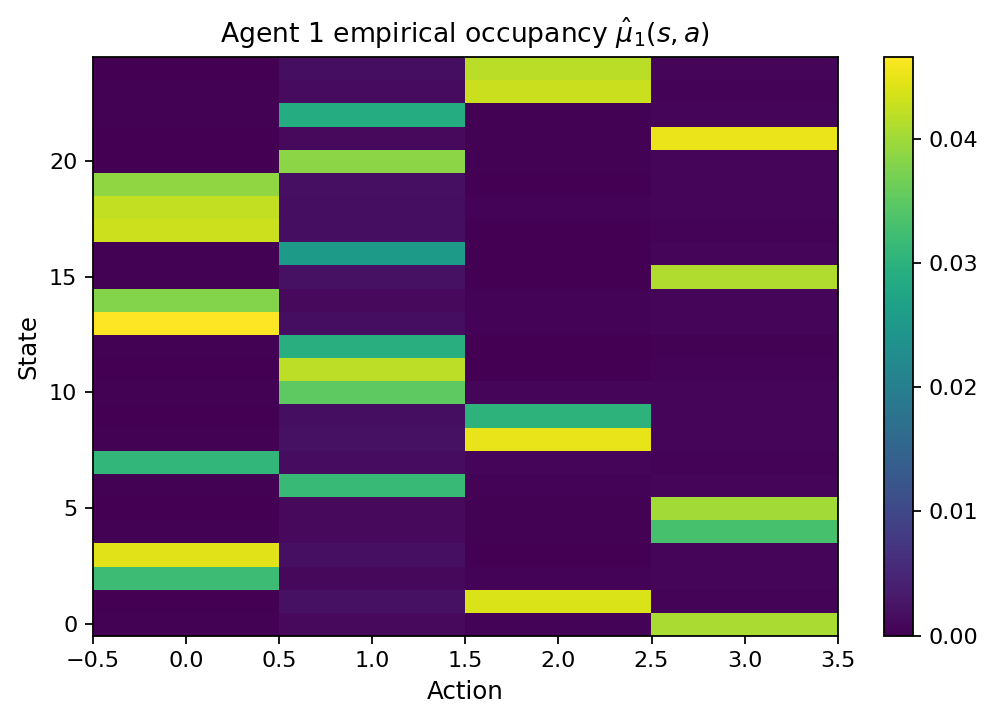

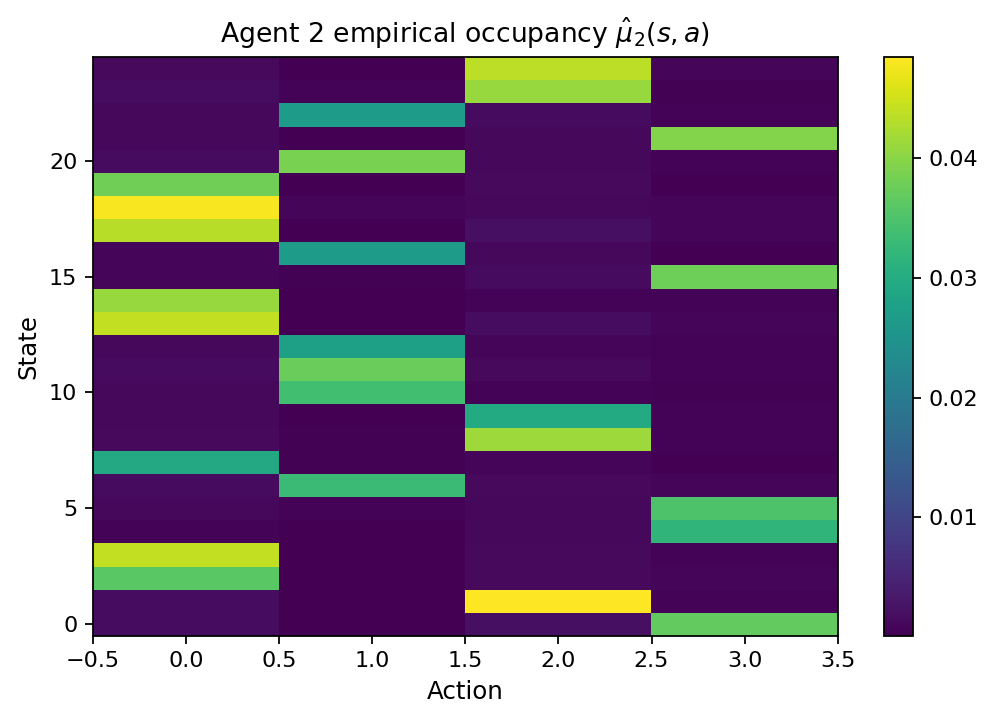

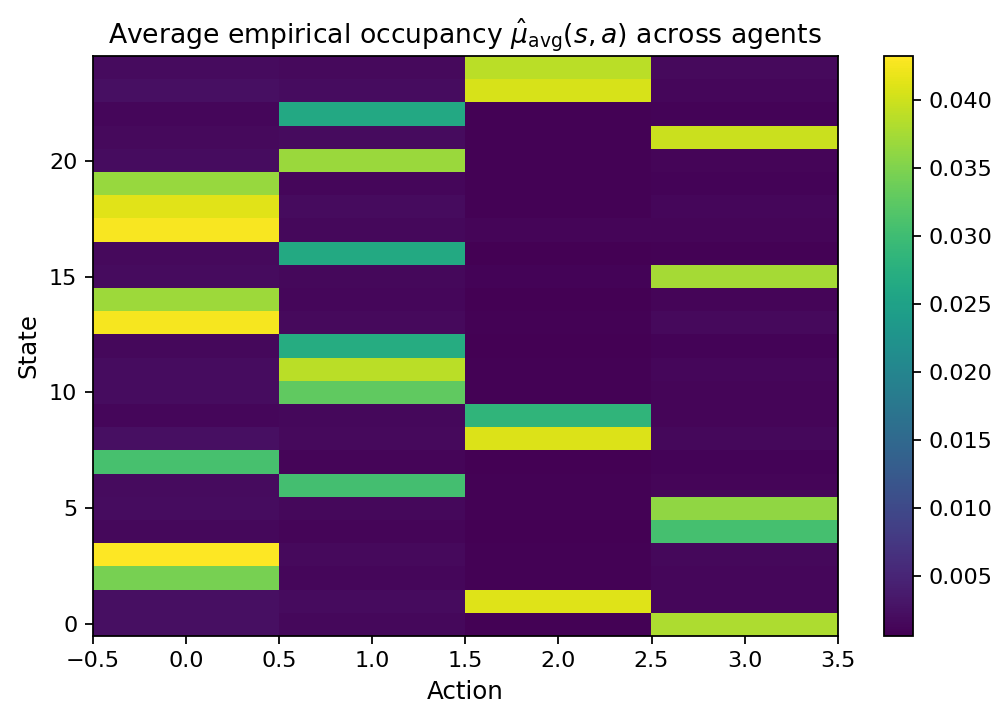

=== Summary (demo) ===
States S=25, Actions A=4, Agents K=6, gamma=0.90, eta=0.050
Total steps (across agents): 75600
Synchronizations (stages): 6
Final sup-norm error (importance): 3.1161
Final sup-norm error (uniform):    3.7453
Final sup-norm error (centralized, last point): 1.2913
Empirical min entry of average occupancy  min_{s,a} \hat{\mu}_avg(s,a) ≈ 0.000582
Empirical worst single-agent occupancy   min_{k,s,a} \hat{\mu}_k(s,a) ≈ 0.000000


In [3]:
# Federated Q-learning with Importance Averaging (Algorithm 1) — demo implementation
# This script:
#   1) Implements Algorithm 1 from the paper (stage-wise, doubling schedule, importance averaging).
#   2) Compares to an unweighted (uniform) averaging baseline and to a centralized single-agent Q-learner.
#   3) Visualizes convergence vs. total steps, stage schedule, and empirical (state,action) occupancies.
#
# Notes:
# - We use a small random ergodic tabular MDP so that Q* can be computed by value iteration.
# - Behavior policies are ε-greedy w.r.t. the broadcast server table, with agent-specific ε floors
#   and action biases to induce heterogeneous coverage.
# - Charts use matplotlib only, one chart per figure, and do not specify colors (as requested).

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1)

# ------------------------------
# MDP construction and Q*
# ------------------------------
def make_random_ergodic_mdp(S, A, gamma, rng):
    """
    Build an ergodic discounted tabular MDP with rewards in [0,1].
    Transition matrix P has a "teleportation" component to ensure ergodicity.
    """
    P = np.zeros((S, A, S), dtype=float)
    R = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            # Base transition from Dirichlet
            base = rng.dirichlet(alpha=np.ones(S))
            # Mix with uniform to ensure ergodicity and aperiodicity
            P[s, a, :] = 0.9 * base + 0.1 * (np.ones(S) / S)
            # Reward in [0,1]
            R[s, a] = rng.beta(2.0, 5.0)
    return P, R

def value_iteration(P, R, gamma, tol=1e-12, max_iter=100000):
    """
    Compute optimal Q* and V* by value iteration.
    """
    S, A, _ = P.shape
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        EV = np.tensordot(P, V, axes=([2], [0]))  # shape (S, A)
        Q = R + gamma * EV
        V_new = np.max(Q, axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    EV = np.tensordot(P, V, axes=([2], [0]))
    Q_star = R + gamma * EV
    return Q_star, V

# Problem size
S = 25           # number of states
A = 4            # number of actions
gamma = 0.90     # discount factor

P, R = make_random_ergodic_mdp(S, A, gamma, rng)
Q_star, V_star = value_iteration(P, R, gamma)

# ------------------------------
# Utilities
# ------------------------------
def argmax_with_random_tie_breaking(q_row, rng):
    max_q = np.max(q_row)
    idxs = np.flatnonzero(q_row == max_q)
    return int(rng.choice(idxs))

def epsilon_greedy(Qref, s, epsilon, bias_dist, rng):
    """
    ε-greedy using a reference table Qref for the greedy action; otherwise sample from bias_dist.
    """
    if rng.random() < epsilon:
        return int(rng.choice(len(bias_dist), p=bias_dist))
    return argmax_with_random_tie_breaking(Qref[s], rng)

def q_learning_local_step(Q_local, s, a, r, s_next, eta, gamma):
    """
    In-place tabular Q-learning update on the local table.
    """
    Q_local[s, a] = (1.0 - eta) * Q_local[s, a] + eta * (r + gamma * np.max(Q_local[s_next]))

# ------------------------------
# Algorithm 1: Federated Q-learning (stage-wise, doubling schedule)
# ------------------------------
def run_federated_q(
    P, R, gamma, K=6, eta=0.05, tau1=200, H_max=6,
    eps_min=0.05, eps_max=0.20, rng=None, weight_mode="importance"
):
    """
    Runs the federated tabular Q-learning algorithm with stage-wise doubling.
    weight_mode: "importance" (Algorithm 1) or "uniform" (baseline)
    Returns logs and artifacts useful for visualization.
    """
    assert weight_mode in ("importance", "uniform")
    S, A, _ = P.shape
    if rng is None:
        rng = np.random.default_rng()

    # Heterogeneous ε floors and heterogeneous exploration biases per agent
    epsilons = np.linspace(eps_min, eps_max, K)
    # Strongly-peaked Dirichlet encourages heterogeneity of action choices under exploration
    biases = rng.dirichlet(0.5 * np.ones(A), size=K)

    # Initialize
    Q_bar = np.zeros((S, A), dtype=float)
    states = rng.integers(0, S, size=K)  # initial states per agent
    stage_lengths = [tau1 * (2 ** h) for h in range(H_max)]
    total_steps = 0

    # Logs
    stage_end_steps = []
    stage_errors = []
    stage_counts_saved = []  # keep counts from a middle stage for visualization
    total_counts_per_agent = np.zeros((K, S, A), dtype=np.int64)

    # Error at time 0
    stage_end_steps.append(0)
    stage_errors.append(np.max(np.abs(Q_bar - Q_star)))

    for h, tau in enumerate(stage_lengths, start=1):
        # Local copies and counts reset at stage start
        Q_locals = np.repeat(Q_bar[None, :, :], K, axis=0)
        counts_stage = np.zeros((K, S, A), dtype=np.int64)

        # Freeze behavior policy within the stage (ε floor and bias fixed)
        for k in range(K):
            s = int(states[k])
            eps = float(epsilons[k])
            bias = biases[k]

            for t in range(tau):
                # ε-greedy w.r.t. broadcasted Q_bar
                a = epsilon_greedy(Q_bar, s, eps, bias, rng)
                # Environment step
                s_next = int(rng.choice(S, p=P[s, a]))
                r = float(R[s, a])
                # Local Q-learning update
                q_learning_local_step(Q_locals[k], s, a, r, s_next, eta, gamma)
                # Visit counts
                counts_stage[k, s, a] += 1
                s = s_next

            # Persist last state to be the start of next stage
            states[k] = s

        # Server aggregation
        if weight_mode == "importance":
            nh = np.sum(counts_stage, axis=0)        # (S, A)
            numerator = np.sum(counts_stage * Q_locals, axis=0)  # (S, A)
            Q_new = Q_bar.copy()
            mask = nh > 0
            Q_new[mask] = numerator[mask] / nh[mask]
            # If nh==0, keep previous value (no-op), as in Alg. 1
        else:  # uniform / unweighted averaging
            Q_new = np.mean(Q_locals, axis=0)

        Q_bar = Q_new

        # Book-keeping
        total_counts_per_agent += counts_stage
        total_steps += K * tau
        stage_end_steps.append(total_steps)
        stage_errors.append(np.max(np.abs(Q_bar - Q_star)))

        # Save counts map from the middle stage for plotting later
        if h == int(np.ceil(H_max / 2)):
            stage_counts_saved.append(np.sum(counts_stage, axis=0))

    return {
        "Q_bar": Q_bar,
        "stage_end_steps": np.array(stage_end_steps, dtype=int),
        "stage_errors": np.array(stage_errors, dtype=float),
        "total_counts_per_agent": total_counts_per_agent,
        "saved_counts_stage_mid": stage_counts_saved[0] if stage_counts_saved else None,
        "stage_lengths": np.array(stage_lengths, dtype=int),
    }

# ------------------------------
# Centralized single-agent baseline (same total steps)
# ------------------------------
def run_centralized_q(P, R, gamma, N_total, eta=0.05, eps=0.10, rng=None, probe_points=250):
    """
    Single-agent tabular Q-learning for N_total environment steps.
    Returns error vs. steps at ~probe_points points.
    """
    S, A, _ = P.shape
    if rng is None:
        rng = np.random.default_rng()
    Q = np.zeros((S, A), dtype=float)
    s = int(rng.integers(0, S))

    steps = []
    errors = []
    report_every = max(1, N_total // probe_points)

    for t in range(1, N_total + 1):
        # ε-greedy w.r.t. its own table (no server here)
        if rng.random() < eps:
            a = int(rng.integers(0, A))
        else:
            a = argmax_with_random_tie_breaking(Q[s], rng)
        s_next = int(rng.choice(S, p=P[s, a]))
        r = float(R[s, a])
        q_learning_local_step(Q, s, a, r, s_next, eta, gamma)
        s = s_next

        if (t % report_every == 0) or (t == N_total):
            steps.append(t)
            errors.append(float(np.max(np.abs(Q - Q_star))))

    return np.array(steps, dtype=int), np.array(errors, dtype=float)

# ------------------------------
# Run experiments
# ------------------------------
K = 6
eta = 0.05
tau1 = 200
H_max = 6

# Alg. 1: Importance averaging
rng_imp = np.random.default_rng(12345)
logs_imp = run_federated_q(P, R, gamma, K=K, eta=eta, tau1=tau1, H_max=H_max,
                           eps_min=0.05, eps_max=0.20, rng=rng_imp, weight_mode="importance")

# Baseline: Uniform averaging
rng_uni = np.random.default_rng(12345)  # same seed for comparability of randomness
logs_uni = run_federated_q(P, R, gamma, K=K, eta=eta, tau1=tau1, H_max=H_max,
                           eps_min=0.05, eps_max=0.20, rng=rng_uni, weight_mode="uniform")

N_total = int(logs_imp["stage_end_steps"][-1])
rng_cen = np.random.default_rng(54321)
steps_cen, errors_cen = run_centralized_q(P, R, gamma, N_total, eta=eta, eps=0.10, rng=rng_cen, probe_points=300)

# ------------------------------
# Empirical occupancies (for heterogeneity / μ_avg intuition)
# ------------------------------
def empirical_mu_from_counts(counts_sa):
    """Normalize a (S,A) count map to a probability table μ(s,a)."""
    total = np.sum(counts_sa)
    if total == 0:
        return np.zeros_like(counts_sa, dtype=float)
    return counts_sa.astype(float) / float(total)

# Per-agent μ-hats
mu_hats = np.array([empirical_mu_from_counts(c) for c in logs_imp["total_counts_per_agent"]])  # (K,S,A)
mu_avg_hat = np.mean(mu_hats, axis=0)  # (S,A)
mu_avg_min_hat = float(np.min(mu_avg_hat))
mu_min_worst_agent_hat = float(np.min(mu_hats))  # min over k,s,a

# ------------------------------
# Visualization 1: Convergence vs. total steps (one chart)
# ------------------------------
plt.figure(figsize=(7.5, 5.0), dpi=160)
# Federated importance averaging: step curve at stage ends
plt.step(logs_imp["stage_end_steps"], logs_imp["stage_errors"], where="post", label="Fed-Q (importance avg., Alg. 1)")
# Federated uniform averaging: step curve
plt.step(logs_uni["stage_end_steps"], logs_uni["stage_errors"], where="post", label="Fed-Q (uniform avg., baseline)")
# Centralized single agent
plt.plot(steps_cen, errors_cen, label="Centralized single-agent Q-learning")
# Stage boundaries (vertical lines)
for s in logs_imp["stage_end_steps"][1:]:
    plt.axvline(s, linestyle="--", linewidth=0.8)
plt.xlabel("Total environment steps across agents")
plt.ylabel(r"$\|\,Q - Q^\star\,\|_\infty$")
plt.title("Convergence vs. total steps\n(Federated importance averaging vs. uniform baseline and centralized)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# Visualization 2: Stage schedule (doubling) — one chart
# ------------------------------
plt.figure(figsize=(6.8, 4.2), dpi=160)
stages = np.arange(1, len(logs_imp["stage_lengths"]) + 1)
plt.plot(stages, logs_imp["stage_lengths"], marker="o")
plt.yscale("log")
plt.xlabel("Stage index h")
plt.ylabel("Per-agent stage length τ_h (log scale)")
plt.title("Doubling schedule τ_h = 2^{h-1} τ_1")
plt.tight_layout()
plt.show()

# ------------------------------
# Visualization 3–5: Occupancy heatmaps (each is its own chart)
# ------------------------------
def show_heatmap(Z, title):
    plt.figure(figsize=(6.6, 4.6), dpi=160)
    plt.imshow(Z, origin="lower", aspect="auto")
    plt.colorbar()
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Agent 1 occupancy
show_heatmap(mu_hats[0], "Agent 1 empirical occupancy $\\hat{\\mu}_1(s,a)$")
# Agent 2 occupancy
if K >= 2:
    show_heatmap(mu_hats[1], "Agent 2 empirical occupancy $\\hat{\\mu}_2(s,a)$")
# Average occupancy across agents
show_heatmap(mu_avg_hat, "Average empirical occupancy $\\hat{\\mu}_{\\mathrm{avg}}(s,a)$ across agents")

# ------------------------------
# Print summary stats
# ------------------------------
print("=== Summary (demo) ===")
print(f"States S={S}, Actions A={A}, Agents K={K}, gamma={gamma:.2f}, eta={eta:.3f}")
print(f"Total steps (across agents): {N_total}")
print(f"Synchronizations (stages): {len(logs_imp['stage_lengths'])}")
print(f"Final sup-norm error (importance): {logs_imp['stage_errors'][-1]:.4f}")
print(f"Final sup-norm error (uniform):    {logs_uni['stage_errors'][-1]:.4f}")
print(f"Final sup-norm error (centralized, last point): {errors_cen[-1]:.4f}")
print(f"Empirical min entry of average occupancy  min_{'{'}s,a{'}'} \\hat{{\\mu}}_avg(s,a) ≈ {mu_avg_min_hat:.6f}")
print(f"Empirical worst single-agent occupancy   min_{'{'}k,s,a{'}'} \\hat{{\\mu}}_k(s,a) ≈ {mu_min_worst_agent_hat:.6f}")


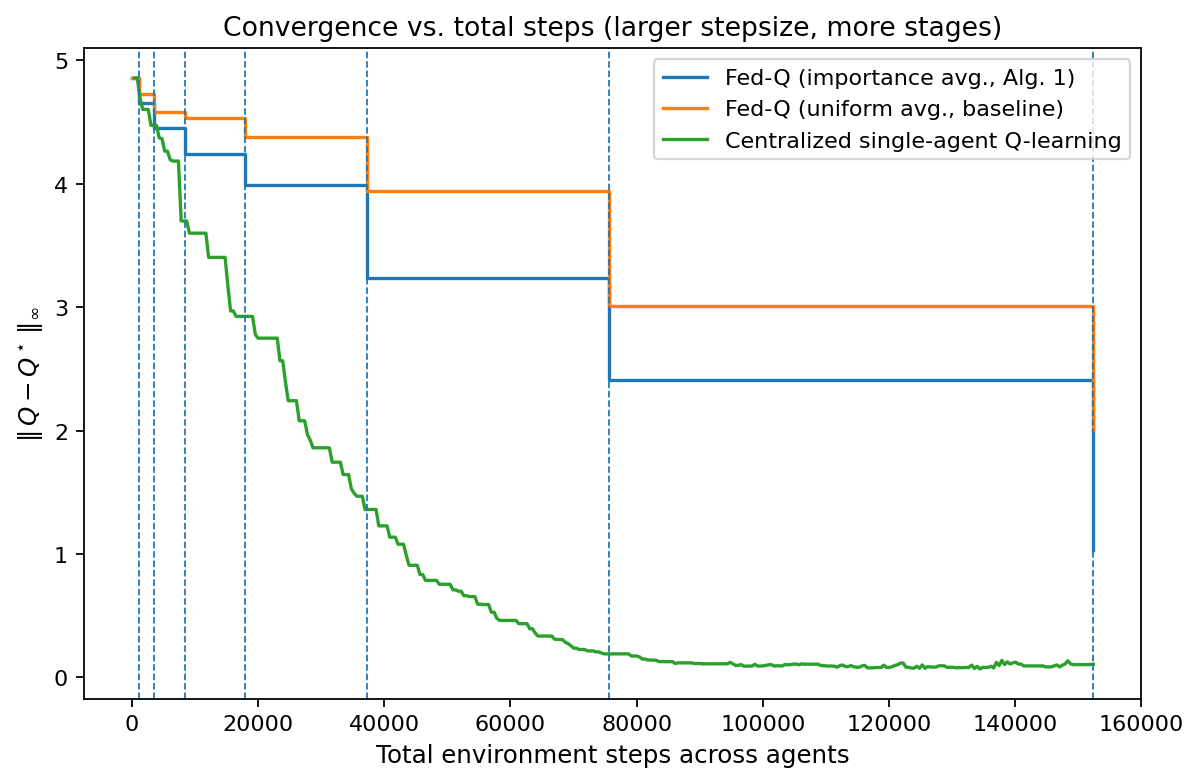

Final errors (eta=0.10, H=7)
Importance-avg Fed-Q: 1.0323
Uniform-avg Fed-Q:    2.0017
Centralized (last):   0.1069
N_total: 152400, #syncs=7


In [5]:

eta = 0.10
H_max = 7  # one more stage

rng_imp = np.random.default_rng(23456)
logs_imp2 = run_federated_q(P, R, gamma, K=K, eta=eta, tau1=tau1, H_max=H_max,
                            eps_min=0.05, eps_max=0.20, rng=rng_imp, weight_mode="importance")

rng_uni = np.random.default_rng(23456)
logs_uni2 = run_federated_q(P, R, gamma, K=K, eta=eta, tau1=tau1, H_max=H_max,
                            eps_min=0.05, eps_max=0.20, rng=rng_uni, weight_mode="uniform")

N_total2 = int(logs_imp2["stage_end_steps"][-1])
rng_cen = np.random.default_rng(65432)
steps_cen2, errors_cen2 = run_centralized_q(P, R, gamma, N_total2, eta=eta, eps=0.10, rng=rng_cen, probe_points=350)

plt.figure(figsize=(7.6, 5.0), dpi=160)
plt.step(logs_imp2["stage_end_steps"], logs_imp2["stage_errors"], where="post", label="Fed-Q (importance avg., Alg. 1)")
plt.step(logs_uni2["stage_end_steps"], logs_uni2["stage_errors"], where="post", label="Fed-Q (uniform avg., baseline)")
plt.plot(steps_cen2, errors_cen2, label="Centralized single-agent Q-learning")
for s in logs_imp2["stage_end_steps"][1:]:
    plt.axvline(s, linestyle="--", linewidth=0.8)
plt.xlabel("Total environment steps across agents")
plt.ylabel(r"$\|\,Q - Q^\star\,\|_\infty$")
plt.title("Convergence vs. total steps (larger stepsize, more stages)")
plt.legend()
plt.tight_layout()
plt.show()

print("Final errors (eta=0.10, H=7)")
print(f"Importance-avg Fed-Q: {logs_imp2['stage_errors'][-1]:.4f}")
print(f"Uniform-avg Fed-Q:    {logs_uni2['stage_errors'][-1]:.4f}")
print(f"Centralized (last):   {errors_cen2[-1]:.4f}")
print(f"N_total: {N_total2}, #syncs={H_max}")
